# TP : Proximal coordinate descent method on regression models

#### Authors: S. Gaiffas, A. Gramfort

## Aim

The aim of this material is to code 
- proximal coordinate descent

for 
- Lasso / L1 linear regression
- non-negative least squares (NNLS)

models.

The proximal operators we will use are the 
- L1 penalization
- indicator function of $\mathbb{R}_+$

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 23th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 17 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "côme"
ln1 = "arvis"
fn2 = "guillaume"
ln2 = "ligner"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_cd", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_cd_arvis_côme_and_ligner_guillaume.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse positive vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

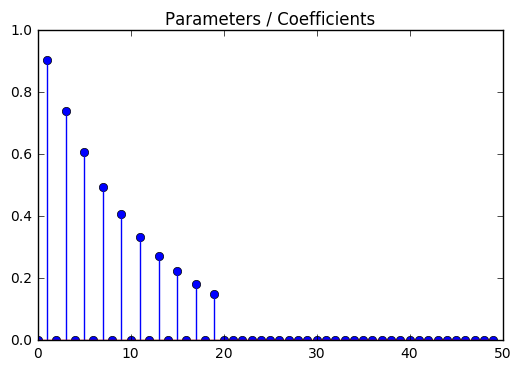

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (idx % 2) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.8):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

## Proximal operators and Solver


We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Lasso penalization, where $g(x) = s \|x\|_1$
- Indicator function of $\mathbb{R}_+$, where $g(x) = i_{x \geq 0}(\cdot)$

where $s \geq 0$ is a regularization parameter.

We want to minimize:
$$
\arg\min_x F(x)
$$
with
$$
 F(x) = \frac{1}{2} \|b - Ax\|^2 + g(x)
$$

## Questions

- Code a function that computes $g(x)$ and $\text{prox}_g(x)$ for in both cases
- Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.
- Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties.
- Evaluate qualitatively the convergence when varying the conditioning of the problem.
- Bonus: Try to show that coordinate is much less affected by bad conditioning that proximal gradient descent.

### You are expected to implement the smart residuals updates !

### You are very welcome to reuse everything you did for TP1 !

In [6]:
def f(x, A, b):
        return 0.5 * np.linalg.norm(b - A.dot(x))**2  

In [7]:
def gradient_i(x, A, b, i):
    return np.dot(A[:, i].T, np.dot(A, x) - b)

def cd_linreg(x0, A, b, g, prox_g, s=0., n_iter=50,
              x_true=coefs, verbose=True, sru = True, cycl = True): 
    
    """Proximal gradient descent algorithm

    Minimize :
    
    1/2 ||b−Ax||^2 + s * g(x)
    
    with coodinate descent.
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x, A, b) + g(x, s)
    objectives.append(obj)

    if verbose:
        print ("Lauching Coordinate Descent solver...")
        print (' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
        
    Li = np.sum(A * A, axis = 0)
    step = 1./Li
    
    res = b - A.dot(x)
    
    for k in range(n_iter + 1):

        if cycl:
            i = k % n_features
        else:
            i = np.random.randint(n_features)
        
        # If we perform the smart residual update, then:
        if sru:
            x_new[i] = prox_g(x[i] + step[i] * np.dot(A[:, i], res), s, step[i]) 
            res -= (x_new[i] - x[i]) * A[:, i]
            x[i] = x_new[i]
        # If not, we just compute the gradient at the column i, and so on:
        else:
            x[i] = prox_g(x[i] - step[i] * gradient_i(x, A, b, i), s, step[i])
        
        obj = f(x, A, b) + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print (' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [8]:
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""    
    return ( np.sign(x) * np.maximum(np.absolute(x) - s*t, np.zeros(x.size)) )

def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    return s * np.linalg.norm(x, ord=1)

""" The interval here is R+*, so if x >= 0 """
def indicator(x, s):
    if np.all(x >= 0): return 0
    else: return np.infty
    
def prox_indicator(x, s, t=1.):
    return np.clip(x, 0, np.infty)

**Question : Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.**

F(x)= 0.5∥b−Ax∥² + g(x) = f(x) + g(x)

with :
g(x) = lasso(x) = sum_1_n(|xi|). Since |x| is convex, g(x) = sum_1_n(|xi|) is also convex. 
g(x) = Indicator(x)_x>=0 is also convex. 
f(x) = 0.5∥b−Ax∥² => gradient(f) = A.T(Ax-b) => dérivées partielles existent et continuent sur R^n => f(x) differentiable.
gradient(x) - gradient(y) = ||0.5 * A.T * A * (x-y) || <= 0.5 * ||A.T * A|| * ||x-y|| => f(x) is L-smooth.
Also we know that 0.5∥b−Ax∥² is convex.

That means that in all the possible cases, f(x) is convex, differentiable on R^n, L-smooth and g(x) is convex. That is why proximal coordinate descent can be applied to obtain a minimum of such objective functions.

In [9]:
x0 = np.zeros(n_features)
s = 1e-1

A, b = simu_linreg(coefs, n_samples=1000, corr=0.4)
A_bis, b_bis = simu_linreg(coefs, n_samples=1000, corr=0.8)

x_min_ind, _, _ = cd_linreg(x0, A, b, indicator, prox_indicator, s, n_iter=30000, x_true=coefs, verbose=False)
x_min_las, _, _ = cd_linreg(x0, A, b, lasso, prox_lasso, s, n_iter=30000, x_true=coefs, verbose=False)
x_min_bis_ind, _, _ = cd_linreg(x0, A_bis, b_bis, indicator, prox_indicator, s, n_iter=30000, x_true=coefs, verbose=False)
x_min_bis_las, _, _ = cd_linreg(x0, A_bis, b_bis, lasso, prox_lasso, s, n_iter=30000, x_true=coefs, verbose=False)

**PLOT ANSWERS:**

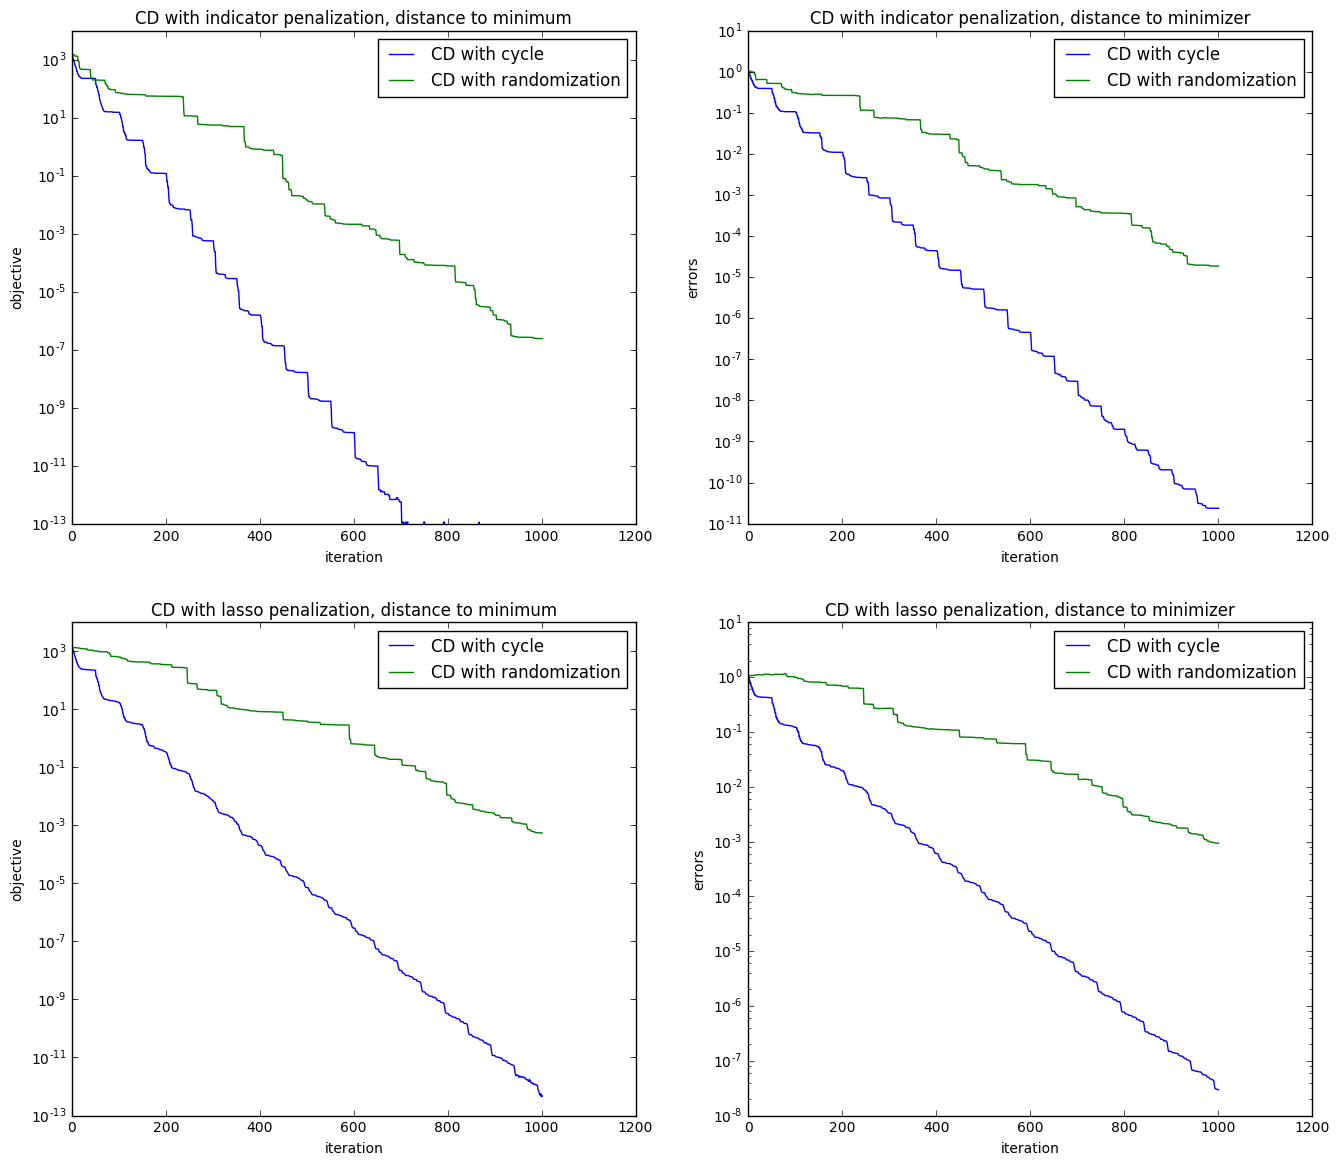

In [14]:
_, objective_ind, errors_ind = cd_linreg(x0, A, b, indicator, prox_indicator, s, n_iter=1000,
              x_true=x_min_ind, verbose=False, sru = True, cycl = True)

_, objective2_ind, errors2_ind = cd_linreg(x0, A, b, indicator, prox_indicator, s, n_iter=1000,
              x_true=x_min_ind, verbose=False, sru = True, cycl = False)

_, objective_las, errors_las = cd_linreg(x0, A, b, lasso, prox_lasso, s, n_iter=1000,
              x_true=x_min_las, verbose=False, sru = True, cycl = True)

_, objective2_las, errors2_las = cd_linreg(x0, A, b, lasso, prox_lasso, s, n_iter=1000,
              x_true=x_min_las, verbose=False, sru = True, cycl = False)

plt.rcParams['figure.figsize'] = (16.0, 14.0)
plt.subplot(2, 2, 1)
plt.yscale('log')
plt.plot(np.array(objective_ind) - (f(x_min_ind, A, b) + indicator(x_min_ind, s)), label="CD with cycle")
plt.plot(np.array(objective2_ind) - (f(x_min_ind, A, b) + indicator(x_min_ind, s)), label="CD with randomization")
plt.xlabel('iteration')
plt.ylabel('objective')
plt.title("CD with indicator penalization, distance to minimum")
plt.legend()
plt.subplot(2, 2, 2)
plt.yscale('log')
plt.plot(errors_ind, label="CD with cycle")
plt.plot(errors2_ind, label="CD with randomization")
plt.xlabel('iteration')
plt.ylabel('errors')
plt.title("CD with indicator penalization, distance to minimizer")
plt.legend()
plt.subplot(2, 2, 3)
plt.yscale('log')
plt.plot(np.array(objective_las) - (f(x_min_las, A, b) + lasso(x_min_las, s)), label="CD with cycle")
plt.plot(np.array(objective2_las) - (f(x_min_las, A, b) + lasso(x_min_las, s)), label="CD with randomization")
plt.xlabel('iteration')
plt.ylabel('objective')
plt.title("CD with lasso penalization, distance to minimum")
plt.legend()
plt.subplot(2, 2, 4)
plt.yscale('log')
plt.plot(errors_las, label="CD with cycle")
plt.plot(errors2_las, label="CD with randomization")
plt.xlabel('iteration')
plt.ylabel('errors')
plt.title("CD with lasso penalization, distance to minimizer")
plt.legend()

In both cases, distance to the minimum and distance to the minimizer, it is clear that the convergence rate is stronger when updating the coordinates UNrandomly, by cycling.  

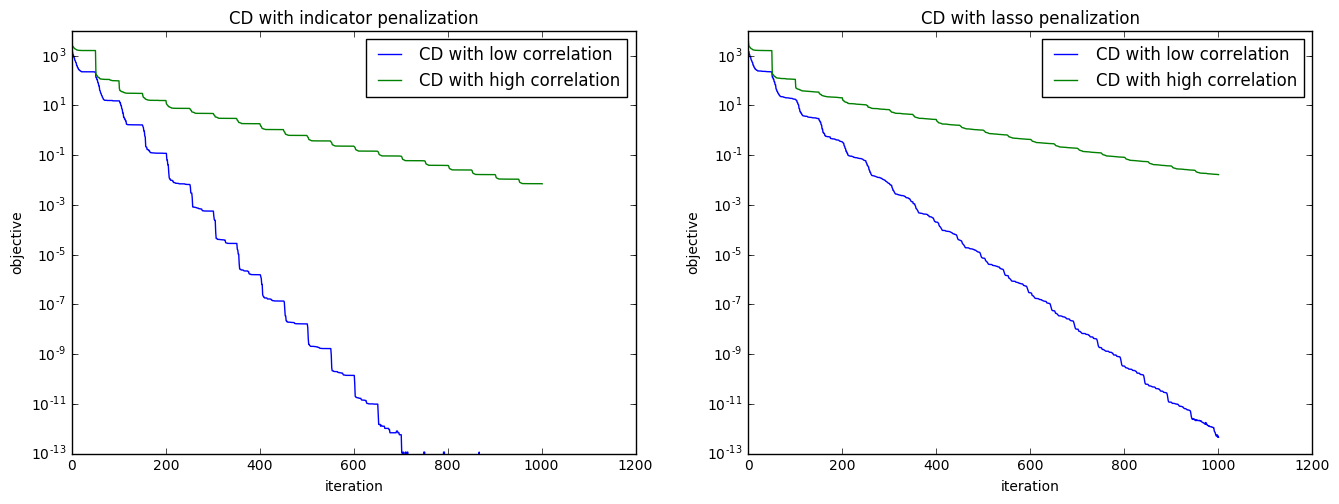

In [11]:
_, objective_ind, _ = cd_linreg(x0, A, b, indicator, prox_indicator, s, n_iter=1000,
              x_true=x_min_ind, verbose=False, sru = True, cycl = True)

_, objective2_ind, _ = cd_linreg(x0, A_bis, b_bis, indicator, prox_indicator, s, n_iter=1000,
              x_true=x_min_bis_ind, verbose=False, sru = True, cycl = True)

_, objective_las, _ = cd_linreg(x0, A, b, lasso, prox_lasso, s, n_iter=1000,
              x_true=x_min_las, verbose=False, sru = True, cycl = True)

_, objective2_las, _ = cd_linreg(x0, A_bis, b_bis, lasso, prox_lasso, s, n_iter=1000,
              x_true=x_min_bis_las, verbose=False, sru = True, cycl = True)

plt.rcParams['figure.figsize'] = (16.0, 12.0)
plt.subplot(2, 2, 1)
plt.yscale('log')
plt.plot(np.array(objective_ind) - (f(x_min_ind, A, b) + indicator(x_min_ind, s)), label="CD with low correlation")
plt.plot(np.array(objective2_ind) - (f(x_min_bis_ind, A_bis, b_bis) + indicator(x_min_bis_ind, s)), label="CD with high correlation")
plt.xlabel('iteration')
plt.ylabel('objective')
plt.title("CD with indicator penalization")
plt.legend()
plt.subplot(2, 2, 2)
plt.yscale('log')
plt.plot(np.array(objective_las) - (f(x_min_las, A, b) + lasso(x_min_las, s)), label="CD with low correlation")
plt.plot(np.array(objective2_las) - (f(x_min_bis_las, A_bis, b_bis) + lasso(x_min_bis_las, s)), label="CD with high correlation")
plt.xlabel('iteration')
plt.ylabel('objective')
plt.title("CD with lasso penalization")
plt.legend()

As we saw previously, correlation leads to lower performances fom optimization algorithms like fista/ista no matter which penelization we choose. Same thing happens here for coordinate descent, as correlation grows the convergence rate of the algorithm lowers more and more. The explanation is that Li is proportional to the correlation between features, --> Li grows as r grows, which leads lower 1/Li as r grows.

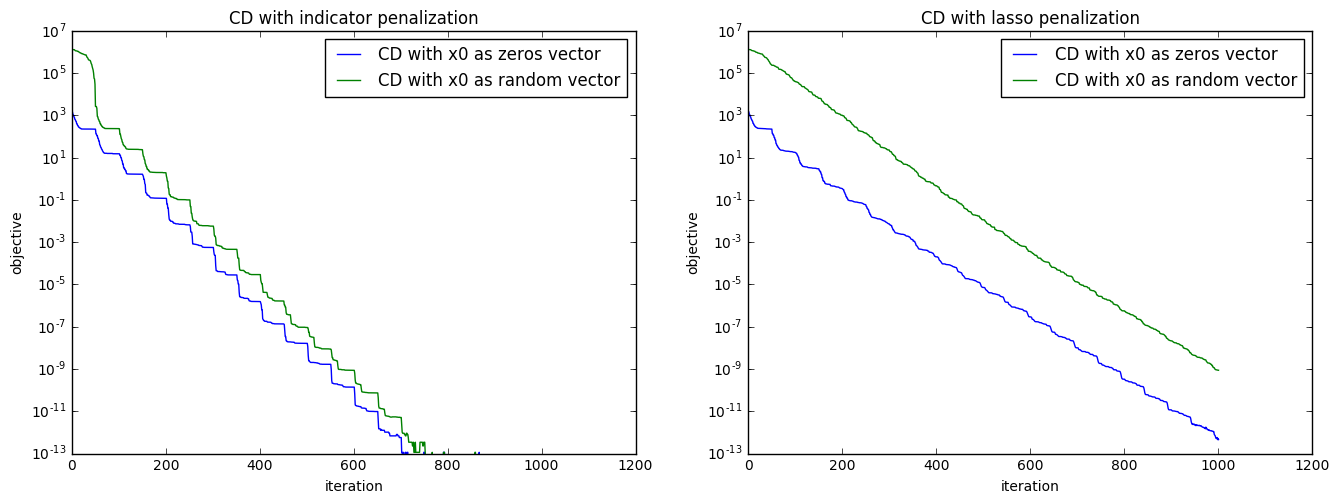

In [12]:
x0 = np.zeros(n_features) 
x0_bis = np.random.random_sample(n_features) * 10

x_min_rand_ind, _, _ = cd_linreg(x0_bis, A, b, indicator, prox_indicator, s, n_iter=30000, x_true=coefs, verbose=False)
x_min_rand_las, _, _ = cd_linreg(x0_bis, A, b, lasso, prox_lasso, s, n_iter=30000, x_true=coefs, verbose=False)

_, objective_ind, _ = cd_linreg(x0, A, b, indicator, prox_indicator, s, n_iter=1000,
              x_true=x_min_ind, verbose=False)

_, objective2_ind, _ = cd_linreg(x0_bis, A, b, indicator, prox_indicator, s, n_iter=1000,
              x_true=x_min_rand_ind, verbose=False)

_, objective_las, _ = cd_linreg(x0, A, b, lasso, prox_lasso, s, n_iter=1000,
              x_true=x_min_las, verbose=False)

_, objective2_las, _ = cd_linreg(x0_bis, A, b, lasso, prox_lasso, s, n_iter=1000,
              x_true=x_min_rand_ind, verbose=False)

plt.rcParams['figure.figsize'] = (16.0, 12.0)
plt.subplot(2, 2, 1)
plt.yscale('log')
plt.plot(np.array(objective_ind) - (f(x_min_ind, A, b) + indicator(x_min_ind, s)), label="CD with x0 as zeros vector")
plt.plot(np.array(objective2_ind) - (f(x_min_rand_ind, A, b) + indicator(x_min_rand_ind, s)), label="CD with x0 as random vector")
plt.xlabel('iteration')
plt.ylabel('objective')
plt.title("CD with indicator penalization")
plt.legend()
plt.subplot(2, 2, 2)
plt.yscale('log')
plt.plot(np.array(objective_las) - (f(x_min_las, A, b) + lasso(x_min_las, s)), label="CD with x0 as zeros vector")
plt.plot(np.array(objective2_las) - (f(x_min_rand_las, A, b) + lasso(x_min_rand_las, s)), label="CD with x0 as random vector")
plt.xlabel('iteration')
plt.ylabel('objective')
plt.title("CD with lasso penalization")
plt.legend()

we see that when starting the algorithm with a random vector, it usually converges faster than starting with a vector full of zeros. Also we notice that in both cases (with indicator and lasso penalization), the 2 curves are almost exactly parallel. Therefore, we can say from this that the starting point doesn't quite change the convergence rate (the curves being parallel), but the vector full of zeros is merely a bad starting point, being usually more distant from xmin than the random starting vectors.

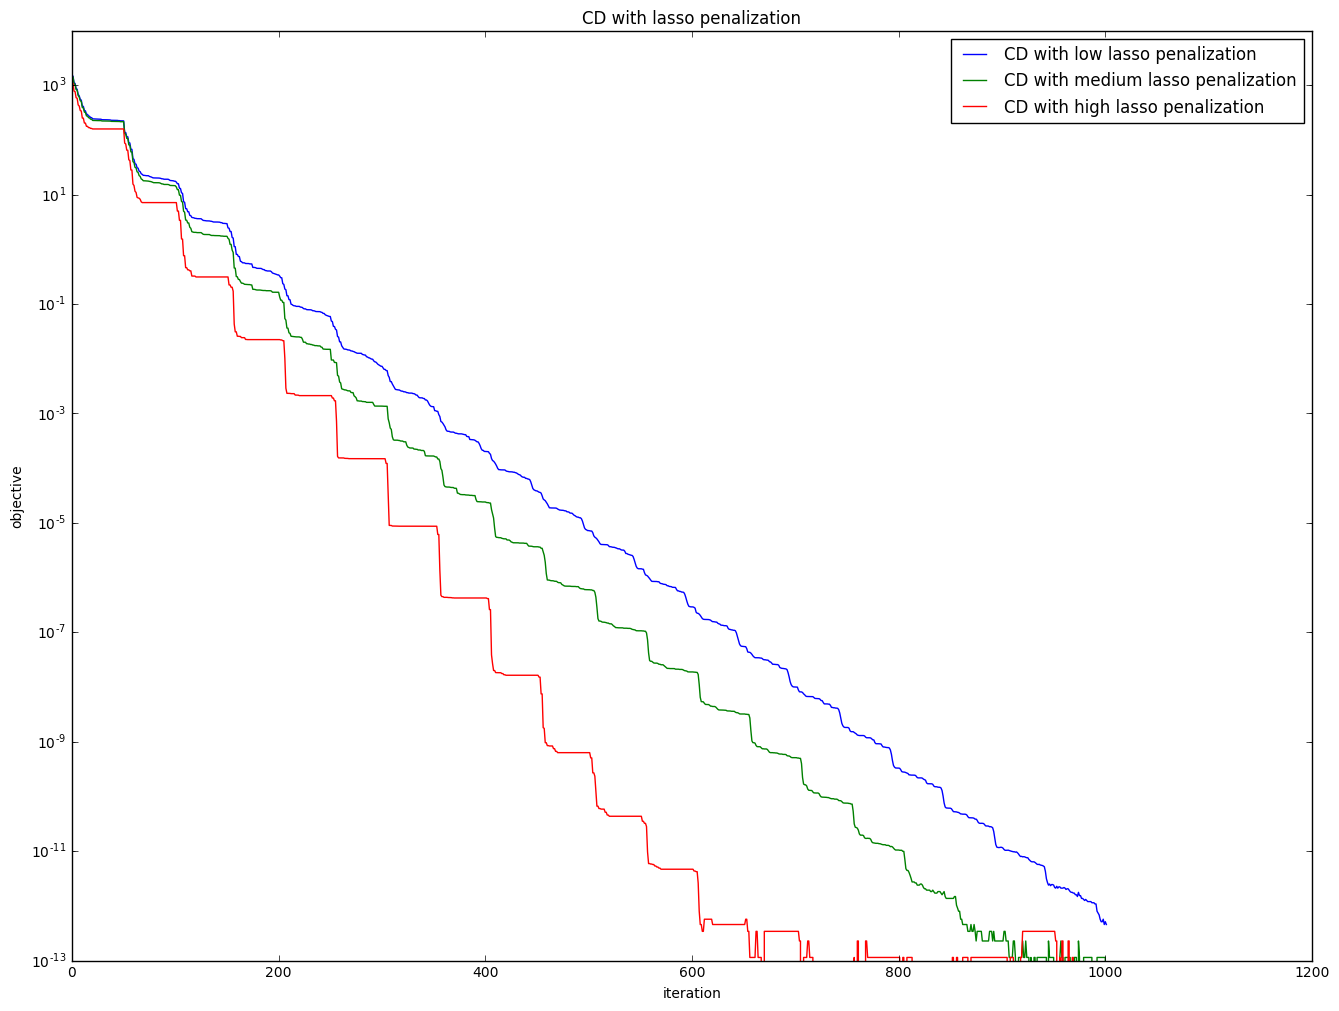

In [23]:
s1 = 0.1
s2 = 10
s3 = 100

x_min_1, _, _ = cd_linreg(x0, A, b, lasso, prox_lasso, s1, n_iter=30000, x_true=coefs, verbose=False)
x_min_2, _, _ = cd_linreg(x0, A, b, lasso, prox_lasso, s2, n_iter=30000, x_true=coefs, verbose=False)
x_min_3, _, _ = cd_linreg(x0, A, b, lasso, prox_lasso, s3, n_iter=30000, x_true=coefs, verbose=False)


_, objective_las, _ = cd_linreg(x0, A, b, lasso, prox_lasso, s1, n_iter=1000,
              x_true=x_min_1, verbose=False)

_, objective2_las, _ = cd_linreg(x0, A, b, lasso, prox_lasso, s2, n_iter=1000,
              x_true=x_min_2, verbose=False)

_, objective3_las, _ = cd_linreg(x0, A, b, lasso, prox_lasso, s3, n_iter=1000,
              x_true=x_min_3, verbose=False)

plt.rcParams['figure.figsize'] = (16.0, 12.0)
plt.subplot(1, 1, 1)
plt.yscale('log')
plt.plot(np.array(objective_las) - (f(x_min_1, A, b) + lasso(x_min_1, s1)), label="CD with low lasso penalization")
plt.plot(np.array(objective2_las) - (f(x_min_2, A, b) + lasso(x_min_2, s2)), label="CD with medium lasso penalization")
plt.plot(np.array(objective3_las) - (f(x_min_3, A, b) + lasso(x_min_3, s3)), label="CD with high lasso penalization")
plt.xlabel('iteration')
plt.ylabel('objective')
plt.title("CD with lasso penalization")
plt.legend()


We can tell that the stronger the penalization is the quicker the algortihm convergers towards a minimum (that depends on the level of penalization). The reason is that we compute  x_k+1 that way = prox_lasso(x[i] + step[i] * np.dot(A[:, i], res), s, step[i]) and prox_lasso is defined as :

def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""    
    return ( np.sign(x) * np.maximum(np.absolute(x) - s*t, np.zeros(x.size)) )
    
It is obvious from that expression that the bigger s is the faster some coordinates will equal zero. Also we know that a coordinate that equals zero will remain at zero with lasso regulization, meaning that such a coordinate will have no more influence in the minimization process to a minimum. s bigger means more coodinates put to zeros which involves less coordinates left with the potential the minimize f + g. Thus the algorithm with a strong s converges more quickly to ITS minimum, which is bigger than the minimum obtained though a less strong regulization.